### This uses a quadTree for search in data from a catalog, then performs 3PCF for convergence by brute force

In [1]:
import fitsio, time, sys
import numpy as np
from mpmath import *
from concurrent.futures import ProcessPoolExecutor as Executor

In [9]:
sys.path.append("/home/joar/google-drive/PhD/NPCF/pyMethodsClasses/")
from QTrees import Point, Rect, QuadTree
from histoStuffs_bckp import *

In [16]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import ImageGrid

cmap=plt.get_cmap('RdBu')

class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

norm = MidpointNormalize(midpoint=0)

In [4]:
file_name = '~/google-drive/PhD/NPCF/codes_npcf/treeCorr/convergence/data/Aardvark_cpy.fit'
data = fitsio.read(file_name)

In [5]:
dataConv=[]
for ii,jj,kk in zip(data["RA"],data["DEC"],data["KAPPA"]):
    dataConv.append(Point(ii,jj,payload=kk))

In [6]:
# for rectangle's domain 
minRA,maxRA=min(data["RA"]),max(data["RA"])
minDEC,maxDEC=min(data["DEC"]),max(data["DEC"])
domWidth=maxRA-minRA
domHeight=maxDEC-minDEC
cx=(maxRA+minRA)/2
cy=(maxDEC+minDEC)/2

In [7]:
domain = Rect(cx, cy, domWidth, domHeight)
qtree = QuadTree(domain)#j second arg pts max per leaf
for point in dataConv:#j allocation of pts in qtree
    qtree.insert(point)
region = Rect(cx, cy, domWidth/4, domHeight/4)
found_points = []
qtree.query(region, found_points)
print('Number of points in the domain =', len(qtree))
print('Number of found points =', len(found_points))

Number of points in the domain = 4997
Number of found points = 585


/tmp/ipykernel_2546/3117329688.py:18: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "DPI" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('search-quadtree.png', DPI=72)


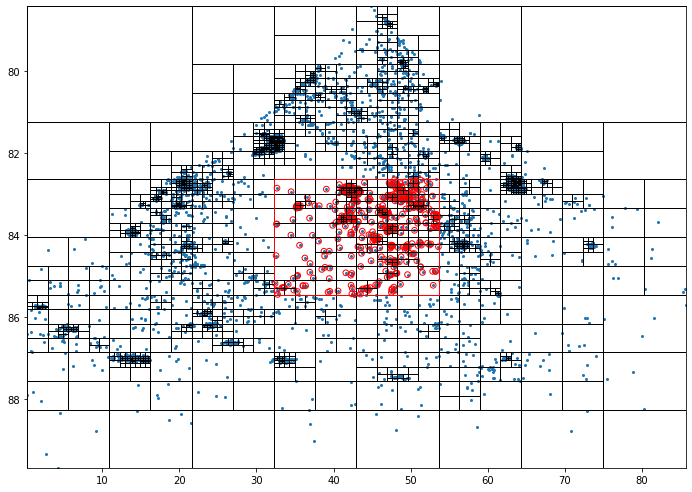

In [8]:
DPI = 72
fig = plt.figure(figsize=(700/DPI, 500/DPI), dpi=DPI)
ax = plt.subplot()
ax.set_xlim(minRA, maxRA)
ax.set_ylim(minDEC, maxDEC)
qtree.draw(ax)
ax.scatter([p.x for p in dataConv], [p.y for p in dataConv], s=4)
#ax.set_xticks([])
#ax.set_yticks([])

ax.scatter([p.x for p in found_points], [p.y for p in found_points],
           facecolors='none', edgecolors='r', s=32)

region.draw(ax, c='r')

ax.invert_yaxis()
plt.tight_layout()
plt.savefig('search-quadtree.png', DPI=72)
plt.show()

In [10]:
found_points[:3]

[(42.4239, 83.6429): -0.00029091458,
 (42.9214, 83.7698): -2.4401572e-05,
 (40.7019, 83.9245): 4.720743e-05]

In [11]:
foundPts=[[p.x,p.y,p.payload] for p in found_points]

In [12]:
nrbin=30 #bins r
nmubin=30 #bins mu
nthtbin=30
nskip=3 #step in pts
rmin= 1.
rmax= 15.

In [13]:
hist_rrtht=np.zeros((nrbin,nrbin,nthtbin))
t1=time.perf_counter()
jobs=[]
Nchunks=10 #threads per job
params=get_params(Nchunks,foundPts)
results=[]
for ii in params:
    #print(type(ii),ii)
    ii.append(nskip)
    ii.append(hist_rrtht)
    jobs.append(Executor(max_workers=2).submit(KKK,ii[0],ii[1],nskip,foundPts,\
               rmin,rmax,hist_rrtht))
for ii in jobs:
    results.append(ii.result())
t2=time.perf_counter()
print("time:%7.2f"%(t2-t1))
for ii in results:
    hist_rrtht+=np.array(ii)

time:  43.48


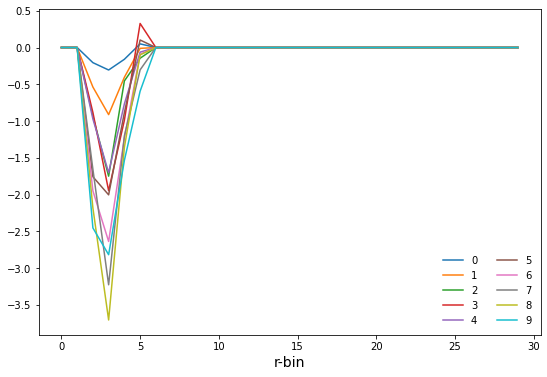

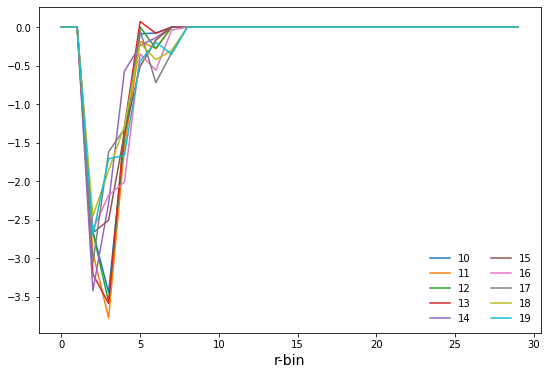

/tmp/ipykernel_2546/2840900680.py:19: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "DPI" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("KKK_rrtht.jpg",DPI=DPI)


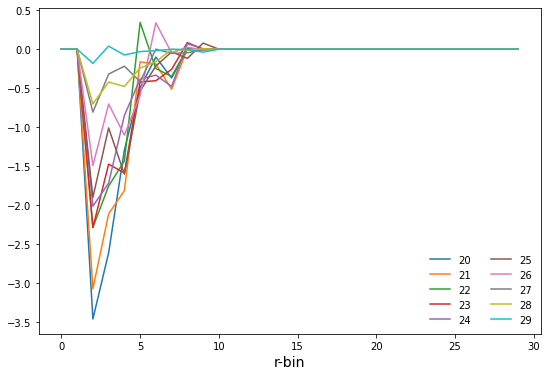

In [14]:
plt.figure(figsize=(9,6))
for ii in range(10):
    plt.plot(np.diagonal(hist_rrtht[:,:,ii]/np.max(hist_rrtht)),label="%d"%(ii))
plt.legend(frameon=False,ncol=2)
plt.xlabel("r-bin",fontsize=14)
plt.show()
plt.figure(figsize=(9,6))
for ii in range(10,20):
    plt.plot(np.diagonal(hist_rrtht[:,:,ii]/np.max(hist_rrtht)),label="%d"%(ii))
plt.legend(frameon=False,ncol=2)
plt.xlabel("r-bin",fontsize=14)
plt.show()
plt.figure(figsize=(9,6))
for ii in range(20,30):
    plt.plot(np.diagonal(hist_rrtht[:,:,ii]/np.max(hist_rrtht)),label="%d"%(ii))
plt.legend(frameon=False,ncol=2)
plt.xlabel("r-bin",fontsize=14)

plt.savefig("KKK_rrtht.jpg",DPI=DPI)
plt.show()

/tmp/ipykernel_2546/3008500559.py:2: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  plt.imshow(hist_rrtht[:,:,29],origin='lower',cmap=cmap,\


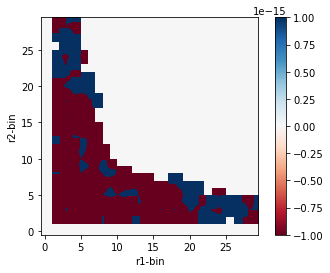

In [17]:
scaleplot=10**(-15)
plt.imshow(hist_rrtht[:,:,29],origin='lower',cmap=cmap,\
    interpolation='bilinear', norm=norm, vmin=-scaleplot,\
    vmax=scaleplot)
plt.colorbar()
plt.ylabel('r2-bin')
plt.xlabel('r1-bin')
plt.show()